In [1]:
# This notebook trains LSTM model on the preprocessed past data

# past_features = [
#     'alberta_internal_load',
#     'forecast_alberta_internal_load',
#     'pool_price',
#     'forecast_pool_price',
#     'rolling_30day_avg_price',
#     'solar_generation',
#     'wind_generation',
#     'temp_calgary',
#     'temp_edmonton',
#     'temp_fortmc',
#     'ws_calgary',
#     'ws_edmonton',
#     'ws_fortmc',
#     'datetime_',
#     'hour_of_day',
#     'day_of_week',
#     'day_of_month',
#     'week_of_month',
#     'month',
#     'year',
#     'is_winter'
# ]


# NVIDIA-SMI 535.183.01 
# CUDA Version: 10.1
# CUDNN Version: 
    #define CUDNN_MAJOR 7
    #define CUDNN_MINOR 6
    #define CUDNN_PATCHLEVEL 5
# Tensorflow Version: 2.2.0
# Python Version: 3.8.10

#### Library

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
import mlflow.tensorflow

# Set pandas display options efficiently
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  

# Suppress specific warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)


In [3]:
# To allocate GPU memory only as required, you can configure TensorFlow using the memory growth option.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

Memory growth enabled for GPUs


2025-03-13 16:50:06.549594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-13 16:50:06.595806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-13 16:50:06.596092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 37.33GiB/s
2025-03-13 16:50:06.596515: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-13 16:50:06.599419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-13 16:50:06.601603: I tensorflow/stream_executor/platform

In [4]:
# check tf version
print('TensorFlow version:', tf.__version__)

#  Check if TensorFlow can access GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("No GPU found, using CPU instead.")

TensorFlow version: 2.2.0
TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Data Loading

In [5]:
# Load the data
df2020 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2020/merged_df_2020_cleaned.csv')
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [6]:
# concatenate all dataframes
df = pd.concat([df2020, df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [7]:
df.shape

(43863, 69)

In [8]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2020-01-01 00:00:00,9467.0,9688.0,30.24,28.79,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
1,2020-01-01 01:00:00,9361.0,9541.0,29.43,28.19,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
2,2020-01-01 02:00:00,9286.0,9410.0,29.66,31.19,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
3,2020-01-01 03:00:00,9209.0,9328.0,28.19,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
4,2020-01-01 04:00:00,9195.0,9319.0,31.17,28.19,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1,28.19,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9209.0,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0


#### Data Pre-processing

In [9]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# sort values by datetime_
df.sort_values('datetime_', inplace=True, ascending=True)

# remove lag terms
df.drop(columns = [col for col in df.columns if col.startswith('alberta_internal_load_lag')], inplace = True)
df.drop(columns = [col for col in df.columns if col.startswith('pool_price_lag')], inplace = True)

In [10]:
df.shape

(43863, 21)

In [11]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter
0,2020-01-01 00:00:00,9467.0,9688.0,30.24,28.79,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1
1,2020-01-01 01:00:00,9361.0,9541.0,29.43,28.19,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1
2,2020-01-01 02:00:00,9286.0,9410.0,29.66,31.19,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1
3,2020-01-01 03:00:00,9209.0,9328.0,28.19,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1
4,2020-01-01 04:00:00,9195.0,9319.0,31.17,28.19,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1


In [12]:
# check for missing observations
(df["datetime_"].diff().dt.total_seconds() // 3600).value_counts()

1.0    43847
0.0       15
Name: datetime_, dtype: int64

In [13]:
df.columns

Index(['datetime_', 'alberta_internal_load', 'forecast_alberta_internal_load',
       'pool_price', 'forecast_pool_price', 'rolling_30day_avg_price',
       'solar_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc',
       'wind_generation', 'ws_calgary', 'ws_edmonton', 'ws_fortmc',
       'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'month',
       'year', 'is_winter'],
      dtype='object')

In [14]:
# Define target column
target_column = "pool_price"

# Exclude datetime column
df = df.drop(columns=["datetime_"])

# Separate features and target
X = df.values 
y = df[target_column].values

# Normalize features using StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - time_steps):
        Xs.append(X[i : i + time_steps])   
        # ys.append(y[i + 1 : i + 1 + time_steps])  
        ys.append(y[i + time_steps : i + time_steps + time_steps])  
    return np.array(Xs), np.array(ys)

# Define sequence length (24 hours)
time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
# X_seq, y_seq = create_sequences(X, y, time_steps)
print(X_seq.shape, y_seq.shape)

(43815, 24, 20) (43815, 24, 1)


#### Train-Test split

In [15]:
# Split into training and testing sets
train_size = int(0.9 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# shape of training and testing sets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(39433, 24, 20) (4382, 24, 20)
(39433, 24, 1) (4382, 24, 1)


#### LSTM modeling

In [16]:
# Enable MLflow Autologging for TensorFlow
mlflow.tensorflow.autolog()

# Start an MLflow Experiment
mlflow.set_experiment("TS_Model_LSTM_Model_Training")

# Define LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), 
    LSTM(1024, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    LSTM(512, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    LSTM(256, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1])
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print Model Summary
model.summary()

# Train Model with MLflow Logging
with mlflow.start_run():
    # Log the model architecture as a text file
    model_summary = []
    model.summary(print_fn=lambda x: model_summary.append(x))
    model_summary_str = "\n".join(model_summary)
    
    # Log architecture as a text file artifact
    with open("lstm_model_structure.txt", "w") as f:
        f.write(model_summary_str)
    
    mlflow.log_artifact("lstm_model_structure.txt")

    # train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict on train data
    y_train_pred = model.predict(X_train)
    # Predict on test data
    y_test_pred = model.predict(X_test)

    # Reverse scaling
    y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
    y_train_inv = scaler_y.inverse_transform(y_train.reshape(y_train.shape[0], y_train.shape[1]))
    # Reverse scaling
    y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))

    # Compute performance metrics
    mae_train = mean_absolute_error(y_train_inv, y_train_pred_inv)
    r2_train = r2_score(y_train_inv, y_train_pred_inv)
    # Compute performance metrics
    mae_test = mean_absolute_error(y_test_inv, y_test_pred_inv)
    r2_test = r2_score(y_test_inv, y_test_pred_inv)

    print(f"Train MAE: {mae_train:.2f}")
    print(f"Train R² Score: {r2_train:.2f}")
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test R² Score: {r2_test:.2f}")

    # Log Custom Metrics 
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)
    # mlflow.log_metric("final_loss", history.history['loss'][-1])
    # mlflow.log_metric("final_mae", history.history['mae'][-1])
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("mae_test", mae_test)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("r2_test", r2_test)
    # Log Model
    # mlflow.tensorflow.log_model(model, "LSTM_Model")

2025/03/13 16:50:09 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.2.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
2025/03/13 16:50:09 ERROR mlflow.tensorflow: Could not log to MLflow because your Tensorflow version is below 2.3, detected version: 2.2.0.
Traceback (most recent call last):
  File "/home/kevin/Downloads/BESS/bess_venv/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/kevin/Downloads/BESS/bess_venv/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/kevin/Downloads/BESS/bess_venv/lib/python3.8/site-packages/mlflow/store/tracki

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 1024)          4280320   
_________________________________________________________________
dropout (Dropout)            (None, 24, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 512)           3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 256)           787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 128)           1

2025-03-13 16:50:29.154003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-13 16:50:29.429528: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


986/986 [==============================] - 172s 175ms/step - loss: 1.0430 - mae: 0.5930 - val_loss: 0.9965 - val_mae: 0.7870
Epoch 2/10
986/986 [==============================] - 203s 206ms/step - loss: 0.9633 - mae: 0.5486 - val_loss: 0.8997 - val_mae: 0.7182
Epoch 3/10
986/986 [==============================] - 231s 234ms/step - loss: 0.9220 - mae: 0.5307 - val_loss: 1.0208 - val_mae: 0.8150
Epoch 4/10
986/986 [==============================] - 251s 255ms/step - loss: 0.8936 - mae: 0.5199 - val_loss: 1.0644 - val_mae: 0.7922
Epoch 5/10
986/986 [==============================] - 235s 239ms/step - loss: 0.8540 - mae: 0.5042 - val_loss: 1.1905 - val_mae: 0.8549
Epoch 6/10
986/986 [==============================] - 303s 307ms/step - loss: 0.8100 - mae: 0.4864 - val_loss: 1.8487 - val_mae: 1.1348
Epoch 7/10
986/986 [==============================] - 263s 267ms/step - loss: 0.7558 - mae: 0.4689 - val_loss: 1.8063 - val_mae: 1.0391
Epoch 8/10
986/986 [==============================] - 318s 

#### Model Performance Check

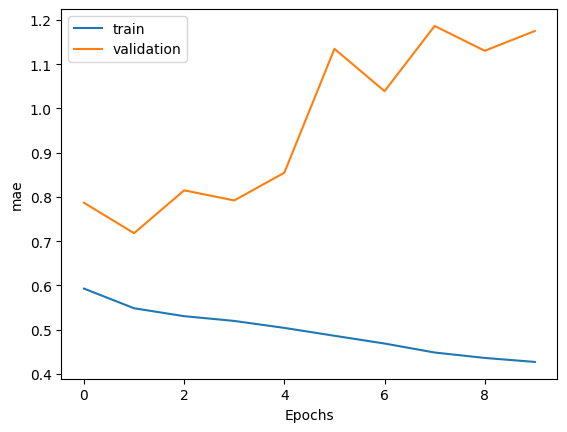

In [17]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

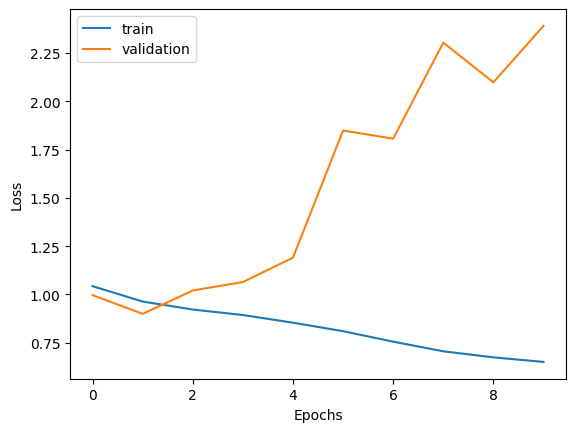

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Predict on train data
y_train_pred = model.predict(X_train)
# Predict on test data
y_test_pred = model.predict(X_test)

# Reverse scaling
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(y_train.shape[0], y_train.shape[1]))
# Reverse scaling
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))

# Compute performance metrics
mae_train = mean_absolute_error(y_train_inv, y_train_pred_inv)
r2_train = r2_score(y_train_inv, y_train_pred_inv)
# Compute performance metrics
mae_test = mean_absolute_error(y_test_inv, y_test_pred_inv)
r2_test = r2_score(y_test_inv, y_test_pred_inv)

print(f"Train MAE: {mae_train:.2f}")
print(f"Train R² Score: {r2_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test R² Score: {r2_test:.2f}")

Train MAE: 87.86
Train R² Score: 0.08
Test MAE: 226.86
Test R² Score: -4.91


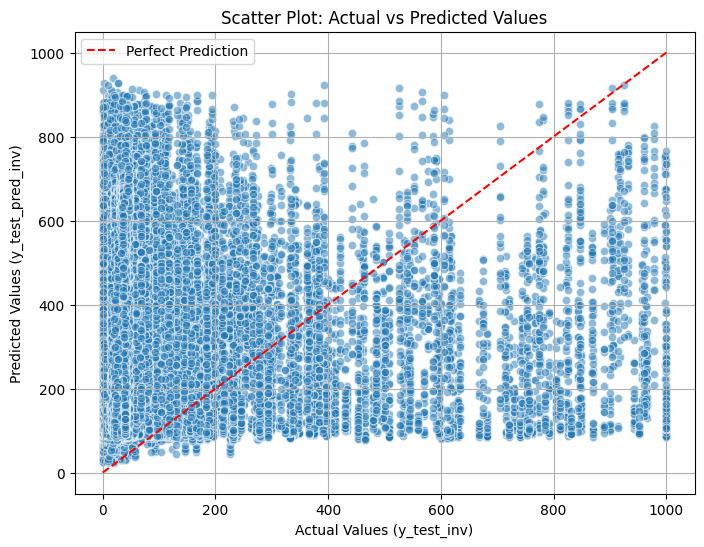

In [20]:
# Flatten the arrays to convert (7011, 24) → (7011*24,)
y_test_inv_flat = y_test_inv.flatten()
y_test_pred_inv_flat = y_test_pred_inv.flatten()

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_inv_flat, y=y_test_pred_inv_flat, alpha=0.5)

# Plot a perfect prediction reference line (y = x)
min_val = min(y_test_inv_flat.min(), y_test_pred_inv_flat.min())
max_val = max(y_test_inv_flat.max(), y_test_pred_inv_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Values (y_test_inv)")
plt.ylabel("Predicted Values (y_test_pred_inv)")
plt.title("Scatter Plot: Actual vs Predicted Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Hourly Statistics

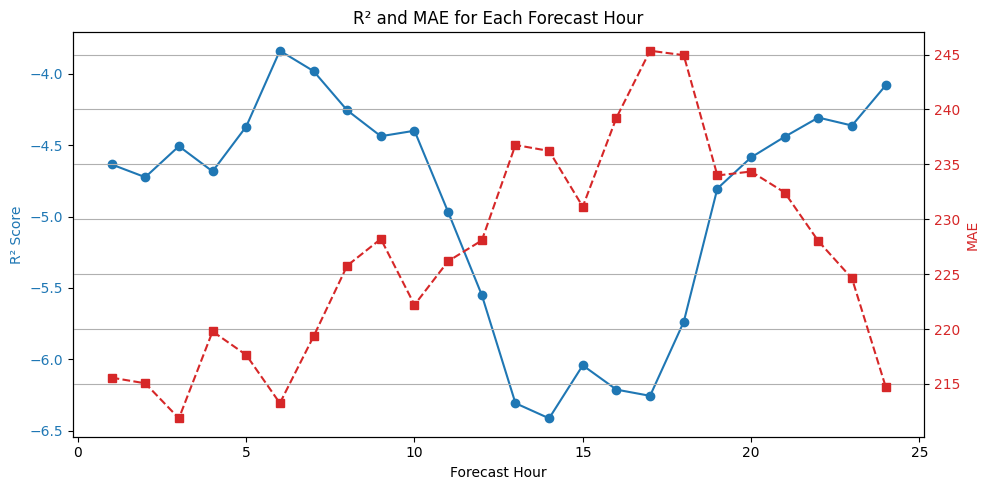

In [21]:
# Initialize lists to store R² and MAE values for each forecast hour
r2_scores = []  
mae_scores = []

# Loop through each forecast hour (24 hours)
for hour in range(24):
    # Calculate R² and MAE for the current hour
    r2 = r2_score(y_test_inv[:, hour], y_test_pred_inv[:, hour])
    mae = mean_absolute_error(y_test_inv[:, hour], y_test_pred_inv[:, hour])
    
    # Append the scores to their respective lists
    r2_scores.append(r2)
    mae_scores.append(mae)

# Convert the lists to NumPy arrays for easy plotting
r2_scores = np.array(r2_scores)
mae_scores = np.array(mae_scores)

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot R² scores on the first y-axis
ax1.set_xlabel("Forecast Hour")  # Label for x-axis
ax1.set_ylabel("R² Score", color="tab:blue")  # Label for left y-axis
ax1.plot(range(1, 25), r2_scores, marker="o", linestyle="-", color="tab:blue", label="R² Score")  # R² plot
ax1.tick_params(axis="y", labelcolor="tab:blue")  # Customize ticks for left y-axis
# ax1.set_ylim(-1, 1)  # R² can be negative, so set the limit between -1 and 1

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.set_ylabel("MAE", color="tab:red")  # Label for right y-axis
ax2.plot(range(1, 25), mae_scores, marker="s", linestyle="--", color="tab:red", label="MAE")  # MAE plot
ax2.tick_params(axis="y", labelcolor="tab:red")  # Customize ticks for right y-axis

# Add a title and layout adjustments
plt.title("R² and MAE for Each Forecast Hour")  # Title for the plot
fig.tight_layout()  # Adjust layout to prevent overlap

# Display the plot
plt.grid()
plt.show()


In [22]:
# run scripts and extract past 24 hours data
# engineer the remaining features
# scale the data
# make predictions